In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import cftime

## Load dataset from Google Cloud

#### Open Google Cloud Storage File System.

In [2]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored.

In [3]:
fs.ls("gs://leap-persistent/sungdukyu")

['leap-persistent/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.input.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.output.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent/sungdukyu/testing']

#### Open the file you want using xarray

In [4]:
# for example, train, input
mapper = fs.get_mapper('leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')

In [5]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 ...
    cam_out_NETSW   (sample, ncol) float64 ...
    cam_out_PRECC   (sample, ncol) float64 ...
    cam_out_PRECSC  (sample, ncol) float64 ...
    cam_out_SOLL    (sample, ncol) float64 ...
    cam_out_SOLLD   (sample, ncol) float64 ...
    ...              ...
    state_q0003     (sample, lev, ncol) float64 ...
    state_t         (sample, lev, ncol) float64 ...
    state_u         (sample, lev, ncol) float64 ...
    state_v         (sample, lev, ncol) float64 ...
    tod             (sample) int32 ...
    ymd             (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

#### Open a file that stores grid information

In [6]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')

In [7]:
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

#### Look, the dataset is on an unstructured grid

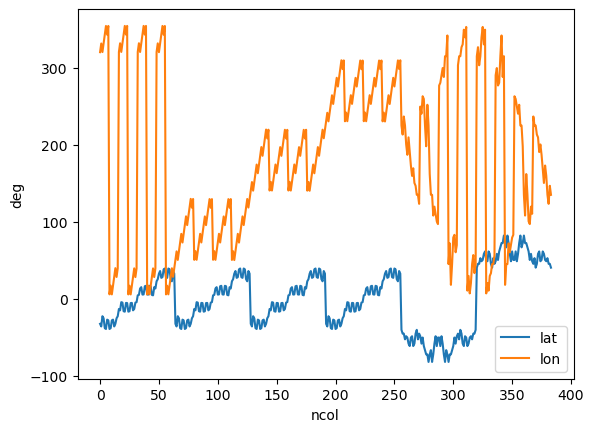

In [8]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

## Now, analysis and visualization can be done as usual using xarray

#### for ease of analysis merge grid info into the main dataset

In [9]:
ds = xr.merge([ds_grid, ds])

#### Optionally, add time dimension

In [10]:
# loop over all sample points
year=ds['ymd']//10000
month=ds['ymd']%10000//100
day=ds['ymd']%10000%100
hour=ds['tod']//3600
minute=ds['tod']%3600//60

k=0
t = []
for k in range(len(ds['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds['sample'] = t
ds = ds.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds

<xarray.Dataset>
Dimensions:         (ncol: 384, ilev: 61, lev: 60, time: 210240)
Coordinates:
  * time            (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: ncol, ilev, lev
Data variables: (12/24)
    P0              float64 ...
    area            (ncol) float64 ...
    hyai            (ilev) float64 ...
    hyam            (lev) float64 ...
    hybi            (ilev) float64 ...
    hybm            (lev) float64 ...
    ...              ...
    state_q0003     (time, lev, ncol) float64 ...
    state_t         (time, lev, ncol) float64 ...
    state_u         (time, lev, ncol) float64 ...
    state_v         (time, lev, ncol) float64 ...
    tod             (time) int32 0 1200 2400 3600 ... 81600 82800 84000 85200
    ymd             (time) int32 10201 10201 10201 10201 ... 90131 90131 90131
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

#### [Analysis 1] Global Precipitation

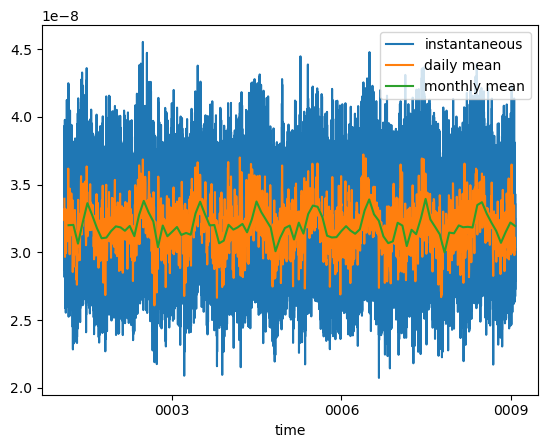

In [11]:
# total precipitation = rainfall + snowfall
PRECT = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']

# area-weighted global mean PRECT
# required concept: avg weights, broadcast, resampling
PRECT_mean = (PRECT * (ds['area']/ds['area'].sum())).sum('ncol')
PRECT_mean_daily = PRECT_mean.resample(time='1D').mean('time')
PRECT_mean_monthly = PRECT_mean.resample(time='1M').mean('time')

# visualization
fig, ax = plt.subplots()
PRECT_mean.plot(label='instantaneous', ax=ax)
PRECT_mean_daily.plot(label='daily mean', ax=ax)
PRECT_mean_monthly.plot(label='monthly mean', ax=ax)
ax.legend()